<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
     <img style="float: right; padding-right: 10px" width="100" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>
     </div>

**Clemson University**<br>
**Instructor(s):** Aaron Masino <br>

## Lab 9A: Recurrent Neural Networks

This lab will introduce you to the creation, training, and evaluation of recurrent neural network models using the [PyTorch](https://pytorch.org/) and [PyTorch Lightning](https://lightning.ai/pytorch-lightning) libraries. PyTorch contains core capabilities related to the development of deep learning models. PyTorch Lightning provides functionally that abstracts much of the process of training and evaluating deep learning models created with PyTorch.

By the end of this lab, you should be able to:
- Evaluate LSTM output dimensions using PyTorch LSTM
- Apply PyTorch LSTM and LSTM concepts to build a text sequence labeling model
- Evaluate text sequence labeling model perforamnce

In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.7 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.functional as F

import lightning as L
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import torchmetrics as TM

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

In [3]:
# Google Colab setup
# mount the google drive - this is necessary to access supporting src
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


We will use a hugging face hub dataset for this lab which requires installation of the `huggingface_hub` Python package. To install this package in your Conda environment execute the following cell:

In [4]:
def create_data_directory(path: str):
    if not os.path.exists(path):
        os.makedirs(path)

dir_dataroot = os.path.join("..", "data")
create_data_directory(dir_dataroot)

dir_lightning = os.path.join("..", "lightning")
create_data_directory(dir_lightning)

SEED = 123456

Execute the following cell to set the `device` variable to the appropriate accelerator for your environment. NOTE: this lab notebook will run extremely slowly without GPU support.

In [5]:
# set device variable to cuda or mps if available otherwise cpu
device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

# Part 1 Sequence Labelling with Recurrent Neural Networks


We will now work with sequence data using the PyTorch `lstm` module which implements the Long Short Term Memory (LSTM) architecture. First, we need to understand the dimension semantics used in PyTorch for data passed into an LSTM cell. The figure below illustrates the expected arrangement Here, we consider the sequence to be
text consisting of a sequence of words. Each word is represented by a set of numbers (the features), often called an __embedding__. <br/><br/>

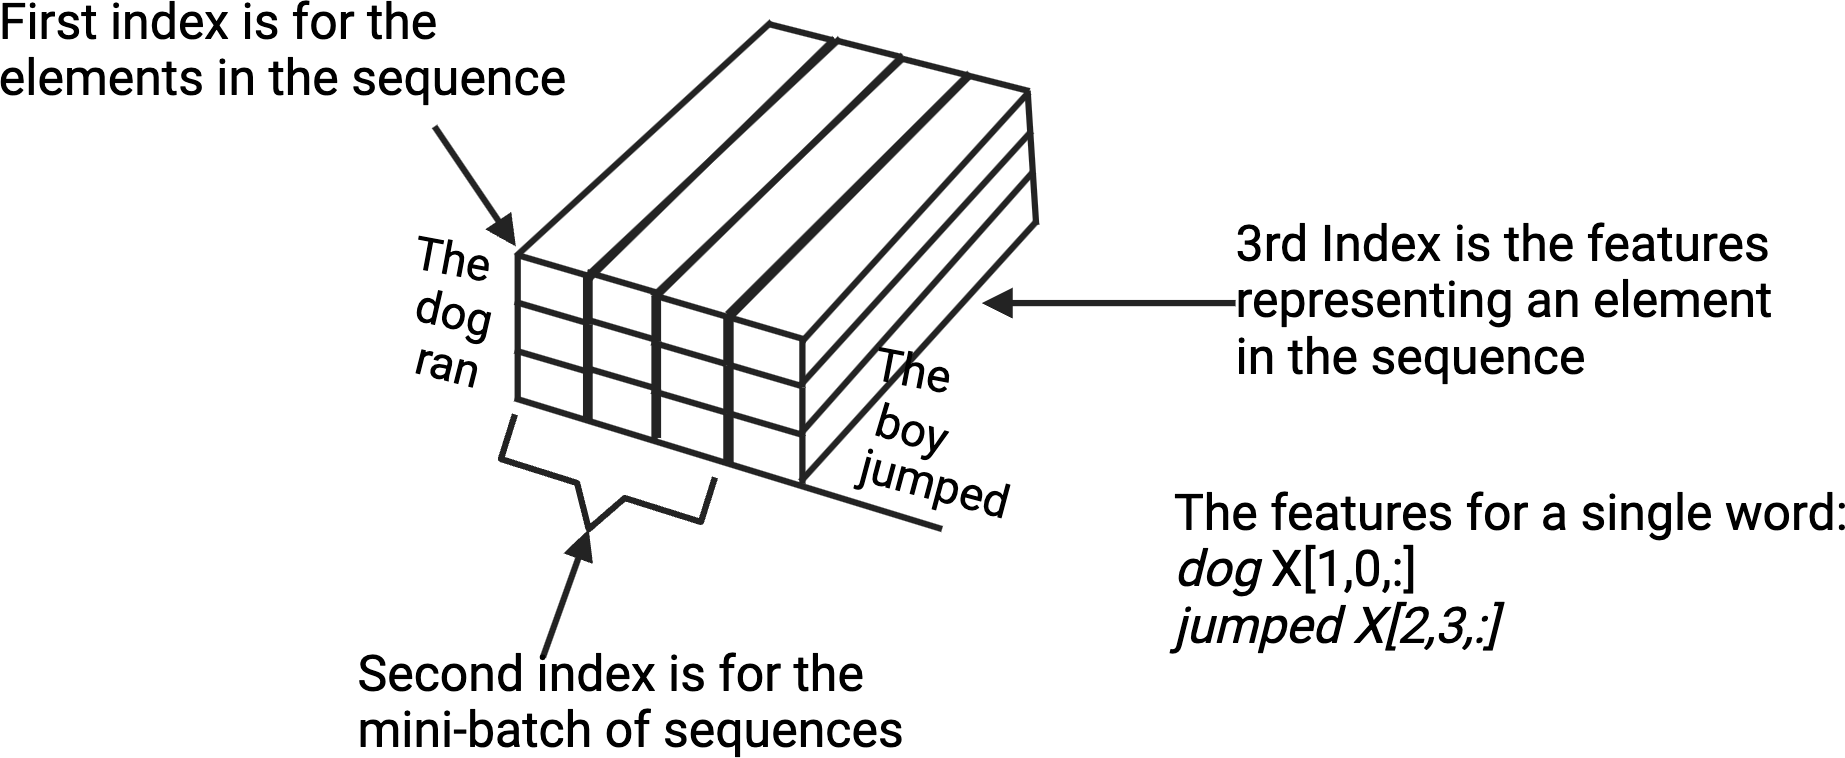

We will begin by passing some Tensors through an `lstm` block to get a better understanding of the data arrangement, the inner workings of the lstm, and the lstm outoupt. Let's start by processing a _single_ sequence. First, we'll process one __element__ in the sequence at a time. Then we'll process the entire sequence.

In [31]:
feature_dim = 10 #the number of features used to represent an element in the sequence, e.g., a word in a sentence
hidden_dim = 20 #the number of features in the hidden state
seq_len = 5 #the length of the sequence, for PyTorch every sequence in the batch must have the same length
num_sequences = 1 #the number of sequences in the batch

lstm = nn.LSTM(input_size=feature_dim, hidden_size=hidden_dim)

# create random input data
inputs = torch.randn(seq_len, num_sequences, feature_dim)

# let's process one element in the sequence at a time
print("Processing one element at a time")
for i in range(seq_len):
    out, (cn,hn) = lstm(inputs[i].view(1, num_sequences, feature_dim)) # view is necessary to add a batch dimension after selecting the sequence elements
    print(f"Step {i}: out.shape:{out.shape}, hn.shape:{hn.shape}, cn.shape:{cn.shape}")

# Let's process the entire sequence at once
print("\nProcessing the entire sequence at once")
out, (hn,cn) = lstm(inputs)
print(f"Output shape: {out.shape}")
print(f"Hidden state shape: {hn.shape}")
print(f"Cell state shape: {cn.shape}")

Processing one element at a time
Step 0: out.shape:torch.Size([1, 1, 20]), hn.shape:torch.Size([1, 1, 20]), cn.shape:torch.Size([1, 1, 20])
Step 1: out.shape:torch.Size([1, 1, 20]), hn.shape:torch.Size([1, 1, 20]), cn.shape:torch.Size([1, 1, 20])
Step 2: out.shape:torch.Size([1, 1, 20]), hn.shape:torch.Size([1, 1, 20]), cn.shape:torch.Size([1, 1, 20])
Step 3: out.shape:torch.Size([1, 1, 20]), hn.shape:torch.Size([1, 1, 20]), cn.shape:torch.Size([1, 1, 20])
Step 4: out.shape:torch.Size([1, 1, 20]), hn.shape:torch.Size([1, 1, 20]), cn.shape:torch.Size([1, 1, 20])

Processing the entire sequence at once
Output shape: torch.Size([5, 1, 20])
Hidden state shape: torch.Size([1, 1, 20])
Cell state shape: torch.Size([1, 1, 20])


Now, let's process __multiple__ sequences. First, we'll process one __sequence__ at a time. Then we'll process the entire sequence as a batch.

In [32]:
feature_dim = 10 #the number of features used to represent an element in the sequence, e.g., a word in a sentence
hidden_dim = 20 #the number of features in the hidden state
seq_len = 5 #the length of the sequence, for PyTorch every sequence in the batch must have the same length
num_sequences = 3 #the number of sequences in the batch

lstm = nn.LSTM(input_size=feature_dim, hidden_size=hidden_dim)

# create random input data
inputs = torch.randn(seq_len, num_sequences, feature_dim)

# let's process one sequence in the batch at a time
print("Processing one sequence at a time")
for i in range(num_sequences):
    out, (hn,cn) = lstm(inputs[:,i,:].view(seq_len, 1, feature_dim)) # unsqueeze is necessary to add a batch dimension after selecting the sequence
    print(f"Step {i}: out.shape:{out.shape}, hn.shape:{hn.shape}, cn.shape:{cn.shape}")

# let's process the entire batch
print("\nProcessing the entire batch")
out, (hn, cn) = lstm(inputs)
print(f"Output shape: {out.shape}")
print(f"Hidden state shape: {hn.shape}")
print(f"Cell state shape: {cn.shape}")

Processing one sequence at a time
Step 0: out.shape:torch.Size([5, 1, 20]), hn.shape:torch.Size([1, 1, 20]), cn.shape:torch.Size([1, 1, 20])
Step 1: out.shape:torch.Size([5, 1, 20]), hn.shape:torch.Size([1, 1, 20]), cn.shape:torch.Size([1, 1, 20])
Step 2: out.shape:torch.Size([5, 1, 20]), hn.shape:torch.Size([1, 1, 20]), cn.shape:torch.Size([1, 1, 20])

Processing the entire batch
Output shape: torch.Size([5, 3, 20])
Hidden state shape: torch.Size([1, 3, 20])
Cell state shape: torch.Size([1, 3, 20])


## Part of Speech Tagging
Now we are going to use the `lstm` module to build a _part of speech_ (POS) tagger. The POS tagger will take an input sequence of words forming a sentence and tag each word with its POS (e.g., noun).

### Data
We will be using a corpus of data stored in Pandas DataFrame loaded from hugging face, see [here](https://huggingface.co/datasets/batterydata/pos_tagging) for more information. The DataFrame has two columns, `words` and `labels`.

In [ ]:
df = pd.read_csv("'/content/drive/MyDrive/Colab Notebooks/cpsc-4300-6300/data/battery_data-pos.csv")
display(df.head())
print(df.shape)
# get the unique tags
tags = df['labels'].explode().unique()
print(tags)
print(len(tags))
# get the most frequent tags
tag_counts = df['labels'].explode().value_counts()
print(tag_counts[0:10])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,words,labels
0,"[Confidence, in, the, pound, is, widely, expec...","[NN, IN, DT, NN, VBZ, RB, VBN, TO, VB, DT, JJ,..."
1,"[Chancellor, of, the, Exchequer, Nigel, Lawson...","[NNP, IN, DT, NNP, NNP, NNP, POS, VBN, NN, TO,..."
2,"[But, analysts, reckon, underlying, support, f...","[CC, NNS, VBP, VBG, NN, IN, NN, VBZ, VBN, VBN,..."
3,"[This, has, increased, the, risk, of, the, gov...","[DT, VBZ, VBN, DT, NN, IN, DT, NN, VBG, VBN, T..."
4,"[``, The, risks, for, sterling, of, a, bad, tr...","[``, DT, NNS, IN, NN, IN, DT, JJ, NN, NN, VBP,..."


(13054, 2)
['NN' 'IN' 'DT' 'VBZ' 'RB' 'VBN' 'TO' 'VB' 'JJ' 'NNS' 'NNP' ',' 'CC' 'POS'
 '.' 'VBP' 'VBG' 'PRP$' 'CD' '``' "''" 'VBD' 'EX' 'MD' '#' '(' '$' ')'
 'NNPS' 'PRP' 'JJS' 'WP' 'RBR' 'JJR' 'WDT' 'WRB' 'RBS' 'PDT' 'RP' ':' 'FW'
 'WP$' 'SYM' 'UH' '-NONE-' '-LRB-' '-RRB-' 'LS']
48
labels
NN     44657
IN     33979
NNP    30882
DT     27541
NNS    20344
JJ     19706
,      16256
.      13210
CD     12055
VBD    10302
Name: count, dtype: int64


To make it easier to work with the data, we will create a `DataSet` class that represents the sequence of words and tags as indices from a fixed vocabulary. (More on that below).

In [34]:
class PandasIndexedTextDataSet(torch.utils.data.Dataset):
    def __init__(self, df, text_indicies_column, target_column):
        self.x = df[text_indicies_column]
        self.t = df[target_column]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.Tensor(self.x.iloc[idx]).int(), torch.Tensor(self.t.iloc[idx]).int()

x = [[1,2,-1,-1], [5,6,7,-1], [1,5,8,9]]
t = [[0,0,-1,-1], [1,1,0,-1], [1,0,1,0]]
ds = PandasIndexedTextDataSet(pd.DataFrame({'word_indices': x, 'target': t}), 'word_indices', 'target')

dl = DataLoader(ds, batch_size=2, shuffle=False)
xin, tin = next(iter(dl))
print(type(xin), type(tin))
print(xin)
print(xin.shape)
print(tin)
print(tin.shape)


<class 'torch.Tensor'> <class 'torch.Tensor'>
tensor([[ 1,  2, -1, -1],
        [ 5,  6,  7, -1]], dtype=torch.int32)
torch.Size([2, 4])
tensor([[ 0,  0, -1, -1],
        [ 1,  1,  0, -1]], dtype=torch.int32)
torch.Size([2, 4])


To work with text data, we need to represent each word (and tag) as a number. We will initially do this by mapping each unique word that occurs in our dataset to an integer value. Then, we can reprsent a sequence of words by a list of integers, each corresponding to the mapped integer from the vocabulary.

In [35]:
class IndexedCorpus():
    def __init__(self, df, column):
        self.df = df
        self.column = column
        self.word2idx, self.idx2word = self.build_indices()
        self.max_len = self.get_max_len()

    def build_indices(self):
        word2idx = {}
        idx2word = {}
        idx = 0
        for word_list in self.df[self.column]:
            for word in word_list:
                if word.lower() not in word2idx:
                    word2idx[word.lower()] = idx
                    idx2word[idx] = word.lower()
                    idx += 1
        word2idx['<PAD>'] = idx
        idx2word[idx] = '<PAD>'
        word2idx['<UNK>'] = idx+1
        idx2word[idx+1] = '<UNK>'
        return word2idx, idx2word

    def vocab_size(self):
        return len(self.word2idx)

    def get_max_len(self):
        return max([len(word_list) for word_list in self.df[self.column]])

    def words2indices(self, words, add_padding=True):
        indices = [self.word2idx.get(word.lower(), self.word2idx['<UNK>']) for word in words]
        if add_padding:
            indices += [self.word2idx['<PAD>']] * (self.max_len - len(indices))
        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        return indices

    def wordBatch2IndicesBatch(self, word_batch):
        return [self.words2indices(words) for words in word_batch]

df = pd.DataFrame({'words': [['The', 'dog', 'ran'], ['The', 'boy', 'jumped','high']], 'target':[['N', 'V', 'NN'], ['V', 'NN', 'V', 'ADJ']]})
icw = IndexedCorpus(df, 'words')
print(icw.word2idx)
print(icw.words2indices(df.words.iloc[0]))
print(icw.words2indices(['The', 'dog', 'ran', 'fast']))
print(icw.wordBatch2IndicesBatch(df.words))

ict = IndexedCorpus(df, 'target')
print(ict.word2idx)
print(ict.wordBatch2IndicesBatch(df.target))
df_idx = pd.DataFrame({'words': icw.wordBatch2IndicesBatch(df.words), 'target': ict.wordBatch2IndicesBatch(df.target)})
df_idx
len(df_idx.index)

{'the': 0, 'dog': 1, 'ran': 2, 'boy': 3, 'jumped': 4, 'high': 5, '<PAD>': 6, '<UNK>': 7}
[0, 1, 2, 6]
[0, 1, 2, 7]
[[0, 1, 2, 6], [0, 3, 4, 5]]
{'n': 0, 'v': 1, 'nn': 2, 'adj': 3, '<PAD>': 4, '<UNK>': 5}
[[0, 1, 2, 4], [1, 2, 1, 3]]


2

We can now create a PyTorch LightningDataModule to handle converting our samples to their intger representations and data loading for model training and evaluation.

In [36]:
class PandasIndexedTextDataModule(L.LightningDataModule):
    def __init__(self, df, text_column, target_column, batch_size=32, val_split=0.2, test_split=0.1):
        super().__init__()
        self.df = df
        self.text_column = text_column
        self.target_column = target_column
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split

    def setup(self, stage=None):
        n = len(self.df.index)
        val_size = int(n * self.val_split)
        test_size = int(n * self.test_split)
        train_size = n - val_size - test_size

        # split the data
        self.train = self.df.iloc[:train_size]
        self.val = self.df.iloc[train_size:train_size+val_size]
        self.test = self.df.iloc[train_size+val_size:]

        # create the IndexdCorpus objects using the train data
        self.icw = IndexedCorpus(self.df, self.text_column)
        self.vocab_size = self.icw.vocab_size()
        self.ict = IndexedCorpus(self.df, self.target_column)
        self.num_classes = self.ict.vocab_size()

    def train_dataloader(self):
        ds = PandasIndexedTextDataSet(pd.DataFrame({'words': self.icw.wordBatch2IndicesBatch(self.train[self.text_column]),
                                                    'target': self.ict.wordBatch2IndicesBatch(self.train[self.target_column])}), 'words', 'target')
        return DataLoader(ds, batch_size=self.batch_size, shuffle=False)

    def val_dataloader(self):
        ds = PandasIndexedTextDataSet(pd.DataFrame({'words': self.icw.wordBatch2IndicesBatch(self.val[self.text_column]),
                                                    'target': self.ict.wordBatch2IndicesBatch(self.val[self.target_column])}), 'words', 'target')
        return DataLoader(ds, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        ds = PandasIndexedTextDataSet(pd.DataFrame({'words': self.icw.wordBatch2IndicesBatch(self.test[self.text_column]),
                                                    'target': self.ict.wordBatch2IndicesBatch(self.test[self.target_column])}), 'words', 'target')
        return DataLoader(ds, batch_size=self.batch_size, shuffle=False)

df = pd.DataFrame({'words': [['The', 'dog', 'ran'],
                             ['The', 'boy', 'jumped','high'],
                             ['A', 'dog', 'ran'],
                             ['The', 'dog', 'and', 'boy', 'ran']],
                  'target':[['N', 'V', 'NN'],
                            ['V', 'NN', 'V', 'ADJ'],
                            ['V', 'N', 'NN'],
                            ['N', 'V', 'CC', 'N', 'V']]})
dm = PandasIndexedTextDataModule(df, 'words', 'target', batch_size=2, val_split=0.25, test_split=0.25)
dm.setup()
print(next(iter(dm.train_dataloader())))
print(next(iter(dm.val_dataloader())))
print(next(iter(dm.test_dataloader())))

[tensor([[0, 1, 2, 8, 8],
        [0, 3, 4, 5, 8]], dtype=torch.int32), tensor([[0, 1, 2, 5, 5],
        [1, 2, 1, 3, 5]], dtype=torch.int32)]
[tensor([[6, 1, 2, 8, 8]], dtype=torch.int32), tensor([[1, 0, 2, 5, 5]], dtype=torch.int32)]
[tensor([[0, 1, 7, 3, 2]], dtype=torch.int32), tensor([[0, 1, 4, 0, 1]], dtype=torch.int32)]


### Building the Tagging Model
We are now ready to build our POS tagger. We will again use the PyTorch LightningModule. This implementation requires many changes from our previous models to account for the fact that we're modeling sequence data.

In [ ]:
class LSTMTagger(L.LightningModule):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_tags):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, num_tags)
        self.num_tags = num_tags

        # validation metrics - we will use these to compute the metrics at the end of the validation epoch
        self.val_metrics_tracker = TM.wrappers.MetricTracker(TM.MetricCollection([TM.classification.MulticlassAccuracy(num_classes=num_tags)]), maximize=True)
        self.validation_step_predictions = []
        self.validation_step_targets = []
        self.val_losses = []

        # test metrics - we will use these to compute the metrics at the end of the test epoch
        self.test_roc = TM.ROC(task="multiclass", num_classes=num_tags) # roc and cm have methods we want to call so store them in a variable
        self.test_cm = TM.ConfusionMatrix(task='multiclass', num_classes=num_tags)
        self.test_metrics_tracker = TM.wrappers.MetricTracker(TM.MetricCollection([TM.classification.MulticlassAccuracy(num_classes=num_tags),
                                                            self.test_roc, self.test_cm]), maximize=True)

        # test outputs and targets - we will store the outputs and targets for the test step
        self.test_step_outputs = []
        self.test_step_targets = []
        self.test_losses = []

    def forward(self, X):
        embeds = self.word_embeddings(X.permute(1,0))
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = nn.functional.log_softmax(tag_space, dim=1)
        return tag_scores

    def training_step(self, batch, batch_idx):
        sentences, tags = batch
        tag_scores = self(sentences)
        loss = nn.functional.nll_loss(tag_scores.permute(1,0,2).reshape(-1, self.num_tags), tags.flatten().long())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        sentences, tags = batch
        tag_scores = self(sentences)
        loss = nn.functional.nll_loss(tag_scores.permute(1,0,2).reshape(-1, self.num_tags), tags.flatten().long())
        self.log('val_loss', loss, on_step=True, on_epoch=True)

        # store the outputs and targets for the epoch end step
        self.validation_step_predictions.append(tag_scores.permute(1,0,2).reshape(-1, self.num_tags))
        self.validation_step_targets.append(tags.flatten().long())
        self.val_losses.append(loss)
        return loss

    def test_step(self, batch, batch_idx):
        sentences, tags = batch
        tag_scores = self(sentences)
        loss = nn.functional.nll_loss(tag_scores.permute(1,0,2).reshape(-1, self.num_tags), tags.flatten().long())
        self.log('test_loss', loss, on_step=True, on_epoch=True)

        # store the outputs and targets for the epoch end step
        self.test_step_outputs.append(tag_scores.permute(1,0,2).reshape(-1, self.num_tags))
        self.test_step_targets.append(tags.flatten().long())
        self.test_losses.append(loss)

    # at the end of the epoch compute the metrics
    def on_validation_epoch_end(self):
        # stack all the outputs and targets into a single tensor
        all_preds = torch.vstack(self.validation_step_predictions)
        all_targets = torch.hstack(self.validation_step_targets)

        # compute the metrics
        loss = nn.functional.nll_loss(all_preds, all_targets)
        self.val_metrics_tracker.increment()
        self.val_metrics_tracker.update(all_preds, all_targets)
        self.log('val_loss_epoch_end', np.mean([_.cpu().item() for _ in self.val_losses]))

        # clear the validation step outputs
        self.validation_step_predictions.clear()
        self.validation_step_targets.clear()

    def on_test_epoch_end(self):
        all_preds = torch.vstack(self.test_step_outputs)
        all_targets = torch.hstack(self.test_step_targets)

        self.test_metrics_tracker.increment()
        self.test_metrics_tracker.update(all_preds, all_targets)
        # clear the test step outputs
        self.test_step_outputs.clear()
        self.test_step_targets.clear()
        self.log('test_loss_epoch_end', np.mean([_.cpu().item() for _ in self.test_losses]))

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

We can now train the model.

In [ ]:
seed_everything(SEED)
df = pd.read_csv("'/content/drive/MyDrive/Colab Notebooks/cpsc-4300-6300/data/battery_data-pos.csv")
dm = PandasIndexedTextDataModule(df, 'words', 'labels', batch_size=32, val_split=0.2, test_split=0.1)
dm.setup()

embedding_dim = 10
hidden_dim = 64
model = LSTMTagger(embedding_dim, hidden_dim, dm.vocab_size, dm.num_classes)

trainer = L.Trainer(default_root_dir=dir_lightning,
                    max_epochs=3,
                    callbacks=[EarlyStopping(monitor="val_loss_epoch_end", mode="min", patience=3)])
trainer.fit(model=model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())

INFO: Seed set to 123456
INFO:lightning.fabric.utilities.seed:Seed set to 123456
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIB

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Let's examing the validation set accuracy.

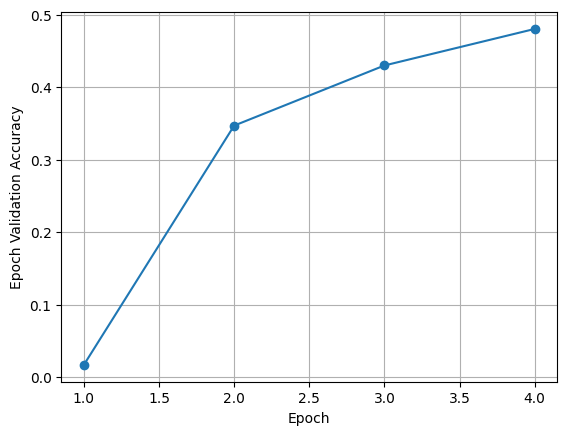

In [39]:
mca = model.val_metrics_tracker.compute_all()['MulticlassAccuracy']
plt.plot(range(1, len(mca)+1), mca, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Epoch Validation Accuracy')
plt.grid()

Finally, let's examine the test set performance.

In [40]:
trainer.test(model=model, dataloaders=dm.test_dataloader())

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    3.2601211071014404     │
│    test_loss_epoch_end    │    3.2588562965393066     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 3.2601211071014404,
  'test_loss_epoch_end': 3.2588562965393066}]

In [41]:
rslt = model.test_metrics_tracker.compute()

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


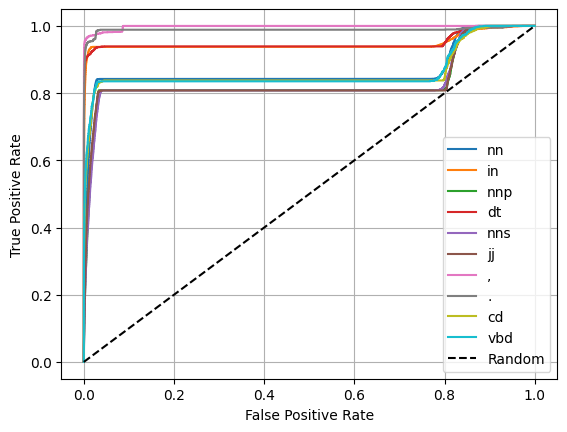

In [42]:
fpr, tpr, thresholds = rslt['MulticlassROC']
indices = [dm.ict.word2idx[idx.lower()] for idx in tag_counts.index[0:10]]
for i in indices:
    plt.plot(fpr[i], tpr[i], label=f'{dm.ict.idx2word[i]}')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()

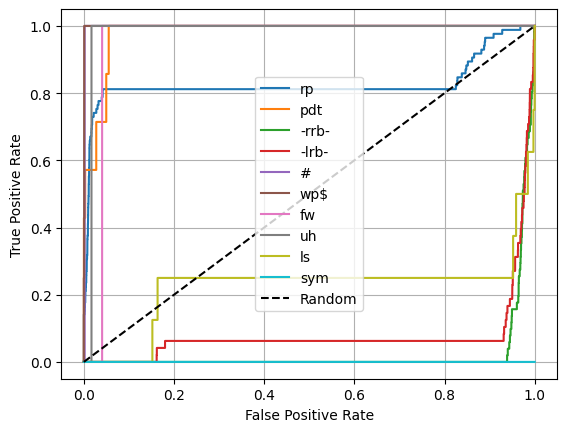

In [43]:
indices = [dm.ict.word2idx[idx.lower()] for idx in tag_counts.index[-10:]]
for i in indices:
    word = dm.ict.idx2word[i]
    plt.plot(fpr[i], tpr[i], label=f'{dm.ict.idx2word[i]}')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()

In [44]:
device = torch.device("cpu")   #"cuda:0"
# put the model in evaluation mode so that the parameters are fixed and we don't compute gradients
model.eval()
y_true=[]
y_pred=[]
# use torch.no_grad() to disable gradient computation

with torch.no_grad():
    # iterate over the test loader minibatches
    for test_data in dm.test_dataloader():
        sentences, tags = test_data
        tag_scores = model(sentences)
        sentences.to(device)
        tags = tags.flatten()
        tags.to(device)
        # store the outputs and targets for the epoch end step
        pred = tag_scores.permute(1,0,2).reshape(-1, model.num_tags).argmax(dim=1)
        # get the images and labels from the test loader and move them to the cpu. this will make it easier to use them with sklearn
        for i in range(len(pred)):
            y_true.append(tags[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=dm.ict.word2idx.keys(),digits=3))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

          nn      0.007     0.133     0.013      4366
          in      0.214     0.538     0.306      3382
          dt      0.265     0.772     0.394      2921
         vbz      0.160     0.486     0.241       782
          rb      0.192     0.241     0.213      1109
         vbn      0.141     0.177     0.157       744
          to      0.130     0.996     0.230       764
          vb      0.136     0.620     0.224       939
          jj      0.204     0.127     0.157      1953
         nns      0.017     0.059     0.027      2015
         nnp      0.351     0.066     0.111      3442
           ,      0.131     0.959     0.231      1841
          cc      0.209     0.894     0.338       836
         pos      0.010     0.917     0.021       230
           .      0.030     0.945     0.058      1322
         vbp      0.088     0.434     0.147       500
         vbg      0.044     0.039     0.041       537
        prp$      0.025    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
